# Lab 2: Supervised Learning
## Dataset: Default of Credit Card Clients
Dataset Link: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### <font color=red>Note that the hyperparameter tuning cells are changed to markdown, please change the cell type to run the code</font>

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

## Data Analysis and Cleaning

Plotting for column PAY_0


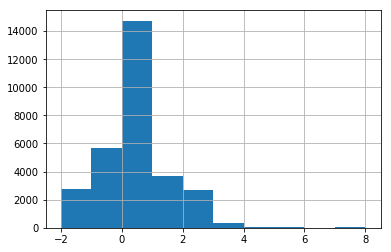

Plotting for column PAY_2


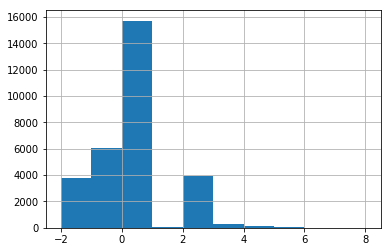

Plotting for column PAY_3


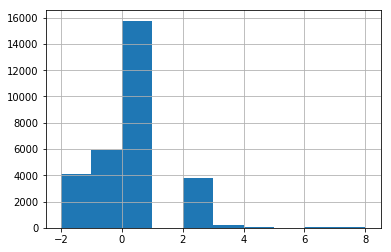

Plotting for column PAY_4


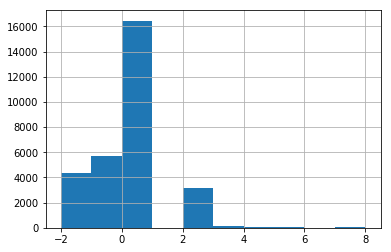

Plotting for column PAY_5


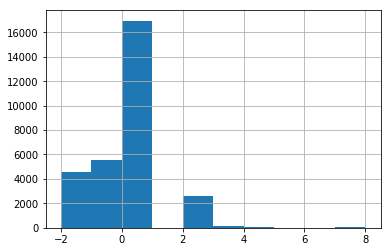

Plotting for column PAY_6


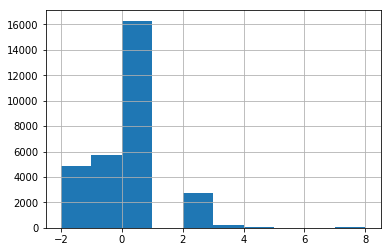

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,male,grad_school,university,high_school,married,single
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
2762,180000,30,0,0,0,0,0,0,113647,52992,38394,30332,110824,99661,3000,3170,2000,100000,5000,4000,0,0,1,0,0,0,1
29311,50000,26,0,0,0,0,0,0,24003,25597,26237,19296,19127,18997,2000,1425,1598,819,705,819,0,1,0,0,1,0,1
14073,320000,43,0,0,0,0,0,0,18625,28143,32159,31851,3105,-45,10000,5000,0,0,0,0,1,1,1,0,0,1,0
22160,230000,29,0,0,0,0,0,0,360,0,0,0,100,900,0,0,0,100,900,715,0,0,1,0,0,0,1
17644,220000,45,0,0,0,0,0,0,142389,143557,142698,145875,143254,145368,6200,7300,7510,5000,5000,5200,0,0,1,0,0,1,0


In [2]:
df = pd.read_excel('default_of_credit_card_clients.xls', index_col="ID", skiprows=[0])

#print(df.head())
#print(df.describe())
#print(df.info())

# One Hot-Coding for categorical features : binary features take values of 1 or 0
# - Scikit-learn might assume these are numerical features
# - can't use labels because Scikit-learn only accepts numbers

# obtain the one hot encoding of columns 'SEX', 'EDUCATION', 'MARRIAGE'
# The base values are: female, other_education, other_marital_status
df['male'] = (df['SEX'] == 1).astype('int')
df.drop('SEX', axis=1, inplace=True)

df['grad_school'] = (df['EDUCATION'] == 1).astype('int')
df['university'] = (df['EDUCATION'] == 2).astype('int')
df['high_school'] = (df['EDUCATION'] == 3).astype('int')
df.drop('EDUCATION', axis=1, inplace=True)

df['married'] = (df['MARRIAGE'] == 1).astype('int')
df['single'] = (df['MARRIAGE'] == 2).astype('int')
df.drop('MARRIAGE', axis=1, inplace=True)

# From the documentation, we can infer that PAY_n features represent not delayed if it is <= 0
pay_n_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in pay_n_features:
    hist = df[col].hist(bins=10)
    print("Plotting for column {}".format(col))
    plt.show()
# modify all values of PAY_n features which are < 0 to 0
for pay_n in pay_n_features:
    df.loc[df[pay_n] <= 0, pay_n] = 0

df.rename(columns={'default payment next month': 'default'}, inplace=True)
    
pd.options.display.max_columns = None
display(df.sample(5))

## Building Machine Learning Models

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler

Plotting for column LIMIT_BAL


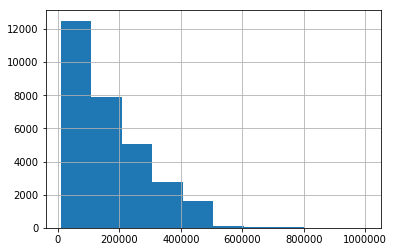

Plotting for column AGE


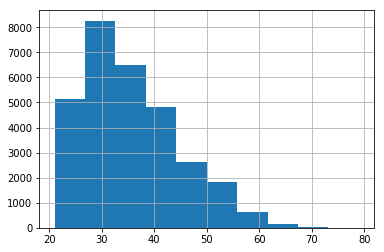

Plotting for column PAY_0


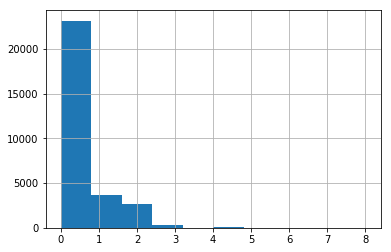

Plotting for column PAY_2


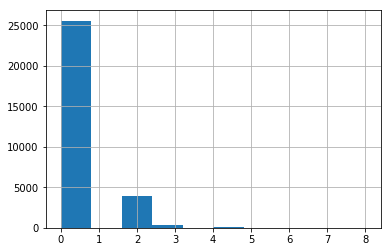

Plotting for column PAY_3


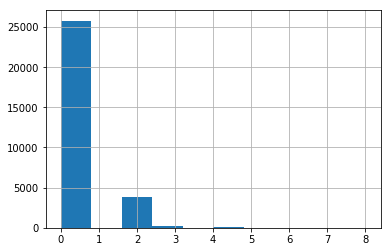

Plotting for column PAY_4


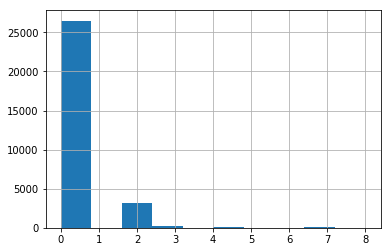

Plotting for column PAY_5


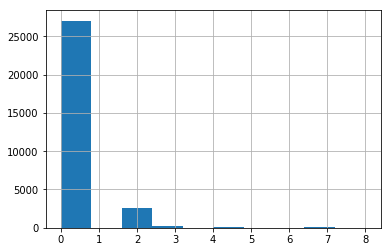

Plotting for column PAY_6


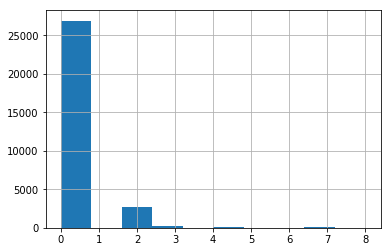

Plotting for column BILL_AMT1


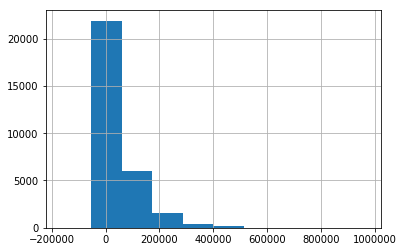

Plotting for column BILL_AMT2


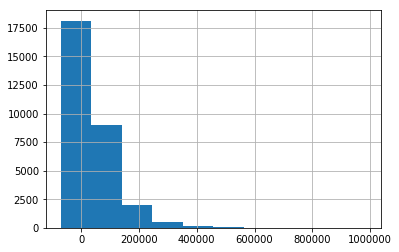

Plotting for column BILL_AMT3


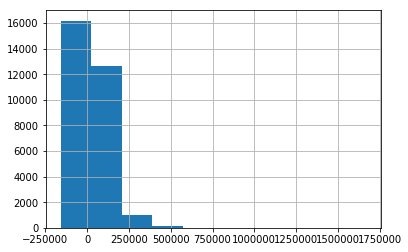

Plotting for column BILL_AMT4


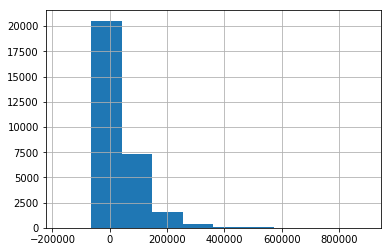

Plotting for column BILL_AMT5


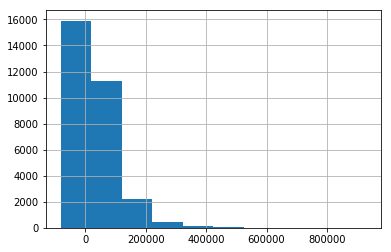

Plotting for column BILL_AMT6


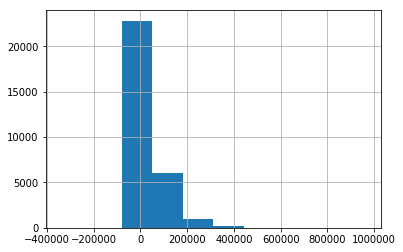

Plotting for column PAY_AMT1


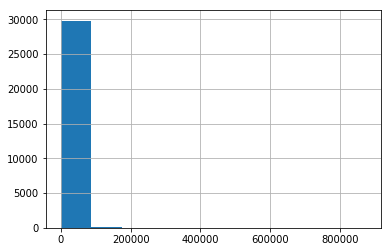

Plotting for column PAY_AMT2


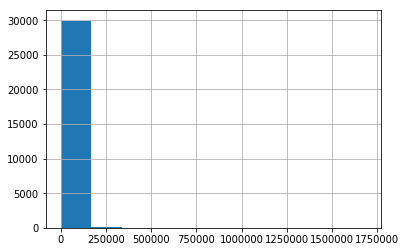

Plotting for column PAY_AMT3


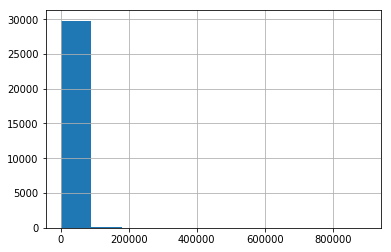

Plotting for column PAY_AMT4


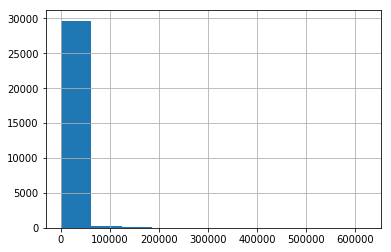

Plotting for column PAY_AMT5


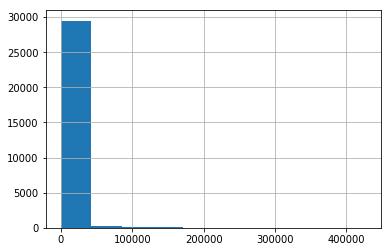

Plotting for column PAY_AMT6


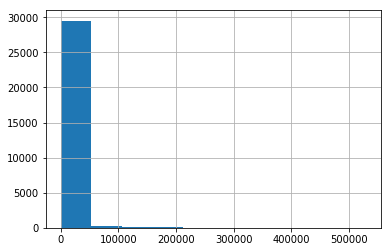

Plotting for column default


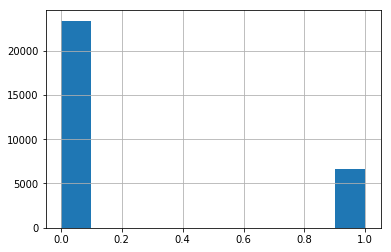

Plotting for column male


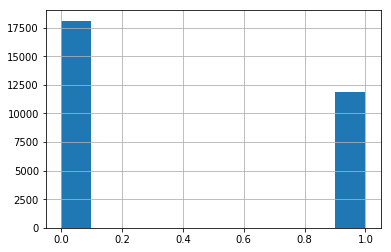

Plotting for column grad_school


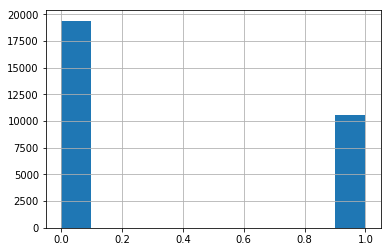

Plotting for column university


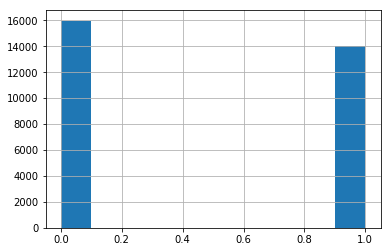

Plotting for column high_school


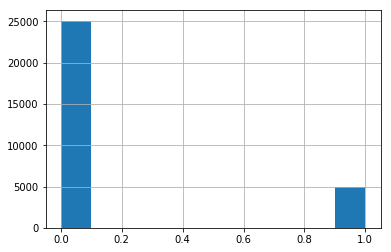

Plotting for column married


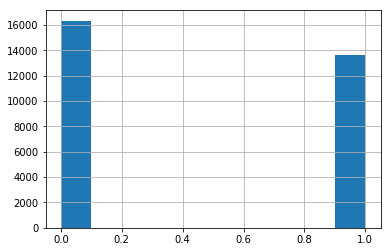

Plotting for column single


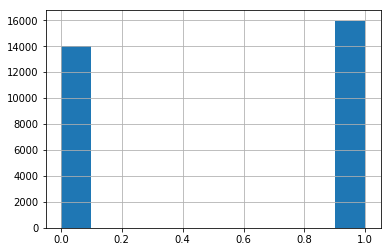

In [4]:
# Feature scaling to get more accurate representation and better learning performance
'''
Most machine learning algorithms take into account only the magnitude of the measurements, not the units of those measurements.
The feature with a very high magnitude (number) may affect the prediction a lot more than an equally important feature.
e.g. the AGE (within certain fixed range) and the PAY_AMTn (monetary) features have very different ranges of values

RobustScaler:
The Robust Scaler uses statistics that are robust to outliers.
This usage of interquartiles means that they focus on the parts where the bulk of the data is.
This makes them very suitable for working with outliers.
Notice that after Robust scaling, the distributions are brought into the same scale and overlap, but the outliers remain outside of bulk of the new distributions.
'''
# plot the distribution of all data
for col in df.columns:
    hist = df[col].hist(bins=10)
    print("Plotting for column {}".format(col))
    plt.show()

x = df.drop('default', axis=1)
rb_scaler = RobustScaler()
x = rb_scaler.fit_transform(x)# rescale all the features to a same range
y = df['default']
# stratify parameter makes data split in a stratified fashion meaning the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=123, stratify=y)

In [5]:
def c_matrix(CM, labels=['pay', 'default']):
    df = pd.DataFrame(data = CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

## Evaluating Model Performance

In [6]:
# Preparing dataframe to store the evaluation metrics
metrics = pd.DataFrame(
    index=['accuracy', 'precision', 'recall', 'f1-score', 'AUC'],
    columns=['LogisticReg', 'DecisionTree', 'NeuralNet']
)

## <font color=red>1. Logistic Regression</font>

### Hyperparameter Tuning for Logistic Regression (Using GridSearchCV)
Tuning regularization penalty and regularization hyperparameter

```python
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# create an instance of the model
log_reg = LogisticRegression(n_jobs=-1)

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
#logspace => Return numbers spaced evenly on a log scale
C = np.logspace(0, 4, 10)

# Create hyperparameter options
params = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(log_reg, params, verbose=0, cv=3)

# Fit grid search
best_model = clf.fit(x_train, y_train)

# Display the best score and best parameters
print("Best mean test score and best parameters:")
print(clf.best_score_, clf.best_params_)
print()

# Loop through and display each pair of mean test score and parameter
print("List of Mean test scores and respective parameters:")
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']
for mean, parameter in zip(means, parameters):
    print(mean, parameter)
```

Actual Machine Learning Model

In [7]:
# import the model class
from sklearn.linear_model import LogisticRegression

# create an instance of the model
log_reg = LogisticRegression(n_jobs=-1, C=2.7825594022071245, penalty='l1')

# train the model using the training data
log_reg.fit(x_train, y_train)

## evaluate the model performance and log the metrics
y_predicted = log_reg.predict(x_test)
probs_log_reg = log_reg.predict_proba(x_test)# predict probabilities
probs_log_reg = probs_log_reg[:, 1]# keep probabilities for the positive outcome only
metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['precision', 'LogisticReg'] = precision_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['recall', 'LogisticReg'] = recall_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['f1-score', 'LogisticReg'] = f1_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['AUC', 'LogisticReg'] = roc_auc_score(y_test, probs_log_reg)

# construct the confusion matrix
CM = confusion_matrix(y_pred=y_predicted, y_true=y_test)
c_matrix(CM)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


PREDICTION,pay,default,Total
TRUE,,,
pay,4480,193,4673
default,892,435,1327
Total,5372,628,6000


```python
## ROC and Precision Recall Curve

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs_log_reg)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-')

plt.title('ROC Curve (Logistic Regression)')

# show the plot
plt.show()
```

## <font color=red>2. Decision Tree Classifier</font>

### Hyperparameter Tuning for Decision Tree Classifier (Using GridSearchCV)
- Tuning max depth, min sample split and criterion

```python
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# create an instance of the model
dec_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10)

# Create max depth space
depths = [None, 5, 10]

# Create minimum sample split space
samples_splits = [2, 4]

# Create criterion space
criteria = ['gini', 'entropy']

# Create hyperparameter options
params = dict(max_depth=depths, min_samples_split=samples_splits, criterion=criteria)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(dec_tree, params, verbose=0, cv=3)

# Fit grid search
best_model = clf.fit(x_train, y_train)

# Display the best score and best parameters
print("Best mean test score and best parameters:")
print(clf.best_score_, clf.best_params_)
print()

# Loop through and display each pair of mean test score and parameter
print("List of Mean test scores and respective parameters:")
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']
for mean, parameter in zip(means, parameters):
    print(mean, parameter)
```

Actual Machine Learning Model

In [8]:
# import the model class
from sklearn.tree import DecisionTreeClassifier

# create an instance of the model
'''
min_samples_split => minimum number of samples required to split an internal node
min_samples_leaf => minimum number of samples required to be at a leaf node
'''
dec_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=10)

# train the model using the training data
dec_tree.fit(x_train, y_train)

## evaluate the model performance and log the metrics
y_predicted = dec_tree.predict(x_test)
probs_dec_tree = dec_tree.predict_proba(x_test)# predict probabilities
probs_dec_tree = probs_dec_tree[:, 1]# keep probabilities for the positive outcome only
metrics.loc['accuracy', 'DecisionTree'] = accuracy_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['precision', 'DecisionTree'] = precision_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['recall', 'DecisionTree'] = recall_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['f1-score', 'DecisionTree'] = f1_score(y_pred=y_predicted, y_true=y_test)
metrics.loc['AUC', 'DecisionTree'] = roc_auc_score(y_test, probs_dec_tree)

# construct the confusion matrix
CM = confusion_matrix(y_pred=y_predicted, y_true=y_test)
c_matrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4459,214,4673
default,864,463,1327
Total,5323,677,6000


```python
## ROC and Precision Recall Curve

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs_dec_tree)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-')

plt.title('ROC Curve (Decision Tree)')

# show the plot
plt.show()
```

## <font color=red>3. Feed Forward Deep Neural Networks</font>

### Hyperparameter Tuning for Sequential Model (Using GridSearchCV)
To use Keras model in Scikit Learn, we need to use the KerasClassifier or KerasRegressor classes. These two classes accept a function which creates and returns a Keras model.
1. Tuning batch size and epochs

```python
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.constraints import unit_norm
from keras.wrappers.scikit_learn import KerasClassifier

def cc_default_classifier():
    input_dim = x_train.shape[1]

    '''
    Weight constraints (unit_norm) provide an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data
    '''
    neuralNet = Sequential()
    neuralNet.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(32, activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(32, activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(16, activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(1,  activation='sigmoid'))

    neuralNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return neuralNet

neuralNet = KerasClassifier(build_fn=cc_default_classifier)

batch_sizes = [24, 32]
epochs = [30, 50]
params = {
    'batch_size': batch_sizes,
    'epochs': epochs,
}

clf = GridSearchCV(neuralNet, params, verbose=2, cv=3)
clf.fit(np.array(x_train), np.array(y_train))

# Display the best score and best parameters
print("Best mean test score and best parameters:")
print(clf.best_score_, clf.best_params_)
print()

# Loop through and display each pair of mean test score and parameter
print("List of Mean test scores and respective parameters:")
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']
for mean, parameter in zip(means, parameters):
    print(mean, parameter)
```

2. Tuning optimizer

```python
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.constraints import unit_norm
from keras.layers.core import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def cc_default_classifier(optimizer):
    input_dim = x_train.shape[1]

    # Weight constraints provide an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data
    neuralNet = Sequential()
    neuralNet.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(32, activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(32, activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(16, activation='relu', kernel_constraint=unit_norm()))
    neuralNet.add(Dropout(0.5))
    neuralNet.add(Dense(1,  activation='sigmoid'))

    neuralNet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return neuralNet

neuralNet = KerasClassifier(build_fn=cc_default_classifier, epochs=50, batch_size=24)

params = {'optimizer':['SGD', 'Adagrad', 'Adam']}

clf = GridSearchCV(neuralNet, params, verbose=2, cv=3)
clf.fit(np.array(x_train), np.array(y_train))

# Display the best score and best parameters
print("Best mean test score and best parameters:")
print(clf.best_score_, clf.best_params_)
print()

# Loop through and display each pair of mean test score and parameter
print("List of Mean test scores and respective parameters:")
means = clf.cv_results_['mean_test_score']
parameters = clf.cv_results_['params']
for mean, parameter in zip(means, parameters):
    print(mean, parameter)
```

Actual Machine Learning Model

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.constraints import unit_norm
from keras.callbacks import Callback

input_dim = x_train.shape[1]

# Weight constraints provide an approach to reduce the overfitting of a deep learning neural network model on the training data and improve the performance of the model on new data
neuralNet = Sequential()
neuralNet.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_constraint=unit_norm()))
neuralNet.add(Dropout(0.5))
neuralNet.add(Dense(32, activation='relu', kernel_constraint=unit_norm()))
neuralNet.add(Dropout(0.5))
neuralNet.add(Dense(32, activation='relu', kernel_constraint=unit_norm()))
neuralNet.add(Dropout(0.5))
neuralNet.add(Dense(16, activation='relu', kernel_constraint=unit_norm()))
neuralNet.add(Dropout(0.5))
neuralNet.add(Dense(1,  activation='sigmoid'))

neuralNet.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

class BatchLogger(Callback):
    def on_train_begin(self, epoch, logs={}):
        self.log_values = {}
        for k in self.params['metrics']:
            self.log_values[k] = []

    def on_epoch_end(self, batch, logs={}):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values[k].append(logs[k])
    
    def get_values(self, metric_name, window):
        d =  pd.Series(self.log_values[metric_name])
        return d.rolling(window,center=False).mean()

bl = BatchLogger()

history = neuralNet.fit(np.array(x_train), np.array(y_train),
              batch_size=24, epochs=50, verbose=1, callbacks=[bl],
              validation_split=0.2)

## evaluate the model performance and log the metrics
# predict probabilities for test set
y_pred_probs = neuralNet.predict(x_test, verbose=0)
# predict crisp classes for test set
y_pred_classes = neuralNet.predict_classes(x_test, verbose=0)

# reduce to 1d array
y_pred_probs = y_pred_probs[:, 0]
y_pred_classes = y_pred_classes[:, 0]

metrics.loc['accuracy', 'NeuralNet'] = accuracy_score(y_test, y_pred_classes)
metrics.loc['precision', 'NeuralNet'] = precision_score(y_test, y_pred_classes)
metrics.loc['recall', 'NeuralNet'] = recall_score(y_test, y_pred_classes)
metrics.loc['f1-score', 'NeuralNet'] = f1_score(y_test, y_pred_classes)
metrics.loc['AUC', 'NeuralNet'] = roc_auc_score(y_test, y_pred_probs)

# construct the confusion matrix
CM = confusion_matrix(y_test, y_pred_classes)
c_matrix(CM)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 19200 samples, validate on 4800 samples
Epoch 1/50
19200/19200 [==============================] - 3s 153us/step - loss: 0.5800 - acc: 0.7668 - val_loss: 0.5235 - val_acc: 0.7794
Epoch 2/50
19200/19200 [==============================] - 2s 97us/step - loss: 0.5259 - acc: 0.7784 - val_loss: 0.4844 - val_acc: 0.7794
Epoch 3/50
19200/19200 [==============================] - 2s 102us/step - loss: 0.5031 - acc: 0.7810 - val_loss: 0.4677 - val_acc: 0.7796
Epoch 4/50
19200/19200 [==============================] - 2s 109us/step - loss: 0.4880 - acc: 0.7880 - val_loss: 0.4574 - val_acc: 0.7865
Epoch 5/50
19200/19200 [==============================] - 2s 94us/step - loss: 0.4786 - acc: 0.7930 - val_loss: 0.4527 - val_acc: 0.7881
Epoch 6/50
19200/19200 [====

PREDICTION,pay,default,Total
TRUE,,,
pay,4442,231,4673
default,848,479,1327
Total,5290,710,6000


```python
## ROC and Precision Recall Curve

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-')

plt.title('ROC Curve (Decision Tree)')

# show the plot
plt.show()
```

In [10]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)

Train: 0.821, Test: 0.820


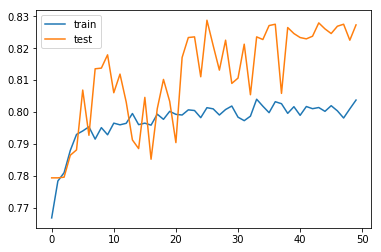

Test log loss: 0.43854478089014687
Test accuracy: 0.8201666666666667


In [11]:
# specific evaluation for neural network
_, train_acc = neuralNet.evaluate(x_train, y_train, verbose=0)
_, test_acc = neuralNet.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

score = neuralNet.evaluate(np.array(x_test), np.array(y_test), verbose=0)
print('Test log loss:', score[0])
print('Test accuracy:', score[1])

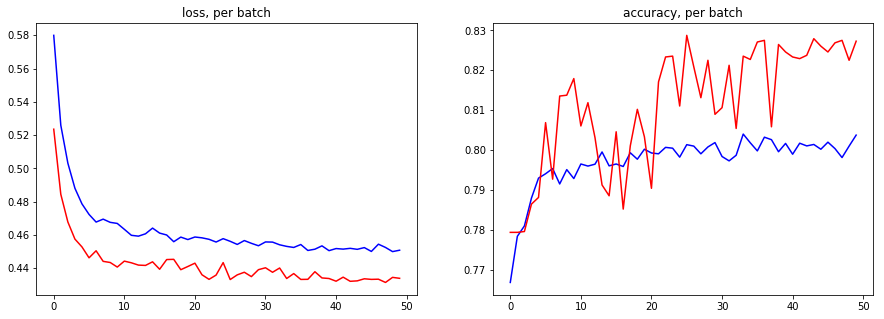

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title('loss, per batch')
plt.plot(bl.get_values('loss',1), 'b-', label='train');
plt.plot(bl.get_values('val_loss',1), 'r-', label='test');

plt.subplot(1, 2, 2)
plt.title('accuracy, per batch')
plt.plot(bl.get_values('acc',1), 'b-', label='train');
plt.plot(bl.get_values('val_acc',1), 'r-', label='test');
plt.show()

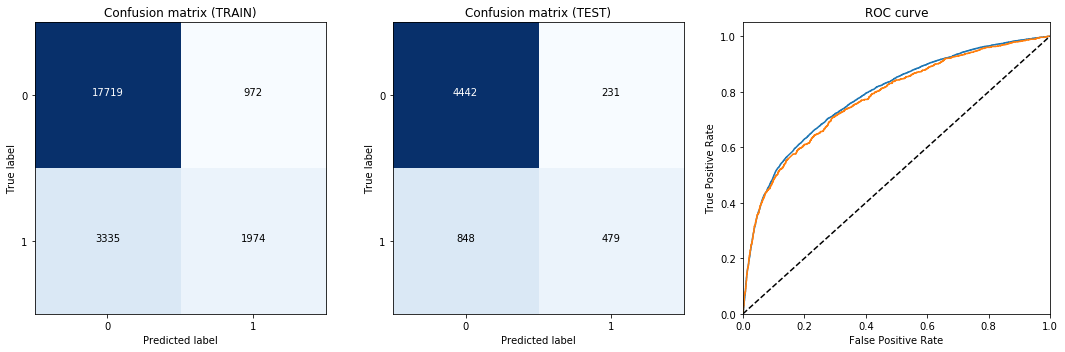

In [13]:
y_train_pred = neuralNet.predict_on_batch(np.array(x_train))[:,0]
y_test_pred = neuralNet.predict_on_batch(np.array(x_test))[:,0]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0], y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)')
plot_cm(ax[1], y_test, y_test_pred, [0,1], 'Confusion matrix (TEST)')

plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred)
    
plt.tight_layout()
plt.show()

## Metrics Analysis and Visualization

In [14]:
100 * metrics

,LogisticReg,DecisionTree,NeuralNet
accuracy,81.9167,82.0333,82.0167
precision,69.2675,68.39,67.4648
recall,32.7807,34.8907,36.0965
f1-score,44.5013,46.2076,47.0299
AUC,76.2671,75.9425,77.6403


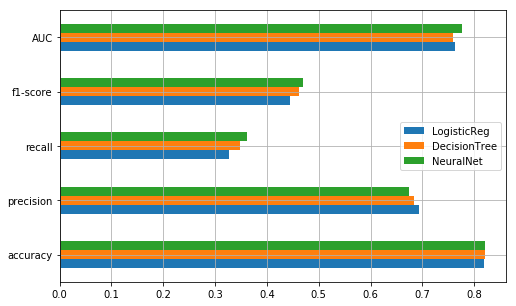

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid()

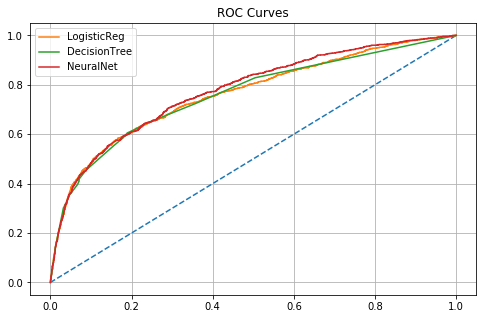

In [16]:
# Plot roc curves for all models
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, log_reg.predict_proba(x_test)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dec_tree.predict_proba(x_test)[:,1])
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, neuralNet.predict(x_test, verbose=0)[:, 0])

fig, ax = plt.subplots(figsize=(8,5))
ax.plot([0, 1], [0, 1], linestyle='--')
ax.plot(fpr_lr, tpr_lr, label='LogisticReg')
ax.plot(fpr_dt, tpr_dt, label='DecisionTree')
ax.plot(fpr_nn, tpr_nn, label='NeuralNet')
ax.set_title('ROC Curves')
ax.legend()
ax.grid()

In [17]:
# Plot precision-recall curves for all models
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, log_reg.predict_proba(x_test)[:,1])
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, dec_tree.predict_proba(x_test)[:,1])
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, neuralNet.predict(x_test, verbose=0)[:, 0])

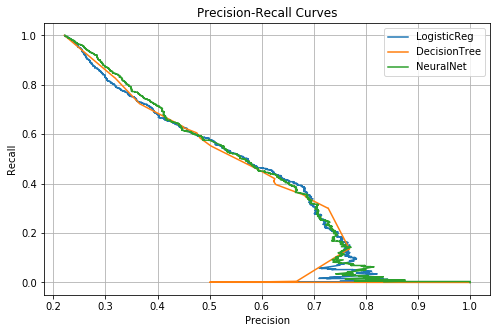

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.plot(precision_dt, recall_dt, label='DecisionTree')
ax.plot(precision_nn, recall_nn, label='NeuralNet')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curves')
ax.legend()
ax.grid()